# **1. Import Library dan Persiapan Awal**

In [ ]:
# Import Library
import pandas as pd
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import joblib
import re
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.utils import class_weight
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist, pdist, squareform
from transformers import AutoTokenizer, AutoModel
from wordcloud import WordCloud

# Tracking waktu eksekusi
start_time = time.time()

# Buat folder untuk output
if not os.path.exists('output'):
    os.makedirs('output')
if not os.path.exists('models'):
    os.makedirs('models')

print("=== ANALISIS PERBANDINGAN ALGORITMA K-NEAREST NEIGHBORS (KNN) DAN DECISION TREE ===")
print("=== BERDASARKAN HASIL SEMANTIC SIMILARITY JUDUL SKRIPSI DAN BIDANG KONSENSTRASI ===")
print("Memulai proses...")

=== ANALISIS PERBANDINGAN ALGORITMA K-NEAREST NEIGHBORS (KNN) DAN DECISION TREE ===
=== BERDASARKAN HASIL SEMANTIC SIMILARITY JUDUL SKRIPSI DAN BIDANG KONSENSTRASI ===
Memulai proses...


# **2. Memuat dan Mempersiapkan Dataset**

In [ ]:
# Upload file judulskripsi.xlsx ke Colab
from google.colab import files
print("\nSilakan upload file dataset Anda (judulskripsi.xlsx)...")
uploaded = files.upload()

# Load Dataset
df = pd.read_excel(list(uploaded.keys())[0])
df.rename(columns={"Unnamed: 0": "judul_skripsi"}, inplace=True)
print(f"\nBerhasil memuat dataset dengan {len(df)} judul skripsi.")
print("Contoh 5 judul skripsi pertama:")
print(df.head())

# Preprocessing teks
def preprocess_text(text):
    # Mengubah ke string jika bukan string
    text = str(text)

    # Ubah ke lowercase
    text = text.lower()

    # Hapus karakter khusus dan angka
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # Hapus multiple spaces
    text = re.sub(r'\s+', ' ', text)

    # Trim spasi di awal dan akhir
    text = text.strip()

    return text

# Preprocessing semua judul
print("\nMelakukan preprocessing teks...")
df['judul_clean'] = df['judul_skripsi'].apply(preprocess_text)


Silakan upload file dataset Anda (judulskripsi.xlsx)...


Saving judulskripsi.xlsx to judulskripsi.xlsx

Berhasil memuat dataset dengan 950 judul skripsi.
Contoh 5 judul skripsi pertama:
                                       judul_skripsi
0  PENERAPAN MODEL PEMBELAJARAN DEMONTRASI UNTUK ...
1  PENGARUH PENGGUNAAN PEMBELAJARAN E-LEARNING BE...
2  PENGEMBANGAN APLIKASI PEMBELAJARAN JARINGAN KO...
3  PENERAPAN METODE PEMBELAJARAN DEMONTRASI UNTUK...
4  PENGARUH PEMANFAATAN MEDIA PEMBELAJARAN BERBAS...

Melakukan preprocessing teks...


# **3. Eksplorasi Data**

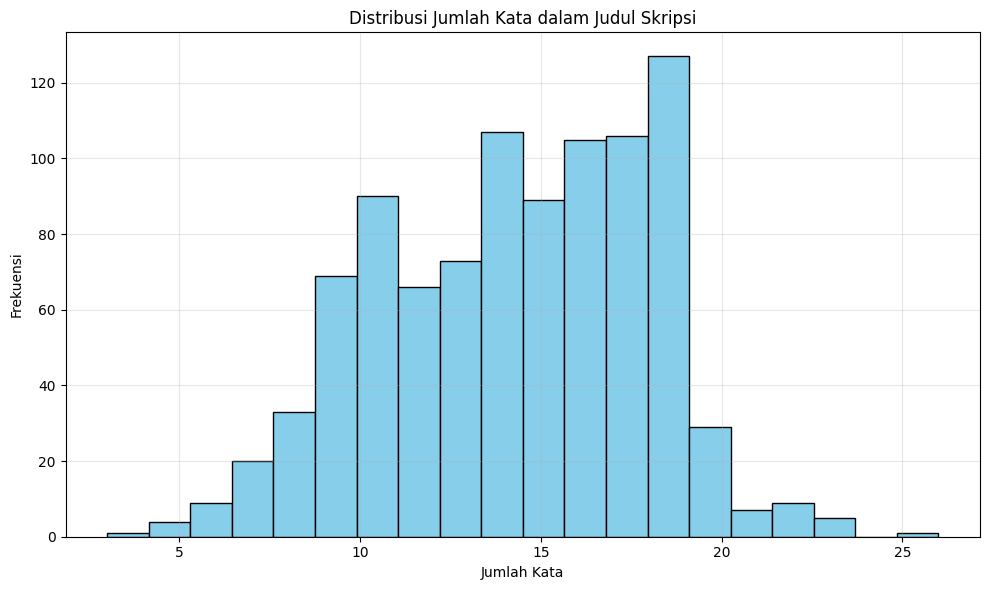


Statistik jumlah kata dalam judul:
Rata-rata: 14.22 kata
Minimum: 3 kata
Maksimum: 26 kata
Median: 15.0 kata


In [ ]:
# Hitung jumlah kata dalam judul
df['word_count'] = df['judul_clean'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))
plt.hist(df['word_count'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribusi Jumlah Kata dalam Judul Skripsi')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.grid(alpha=0.3)
plt.savefig('output/distribusi_jumlah_kata.png')
plt.tight_layout()
plt.show()

print(f"\nStatistik jumlah kata dalam judul:")
print(f"Rata-rata: {df['word_count'].mean():.2f} kata")
print(f"Minimum: {df['word_count'].min()} kata")
print(f"Maksimum: {df['word_count'].max()} kata")
print(f"Median: {df['word_count'].median()} kata")

# **4. Pelabelan Otomatis Berdasarkan Kata Kunci**


Melakukan pelabelan otomatis berdasarkan bidang konsentrasi...

Distribusi Bidang Konsentrasi:
Jaringan: 342 (36.00%)
RPL: 327 (34.42%)
Multimedia: 281 (29.58%)


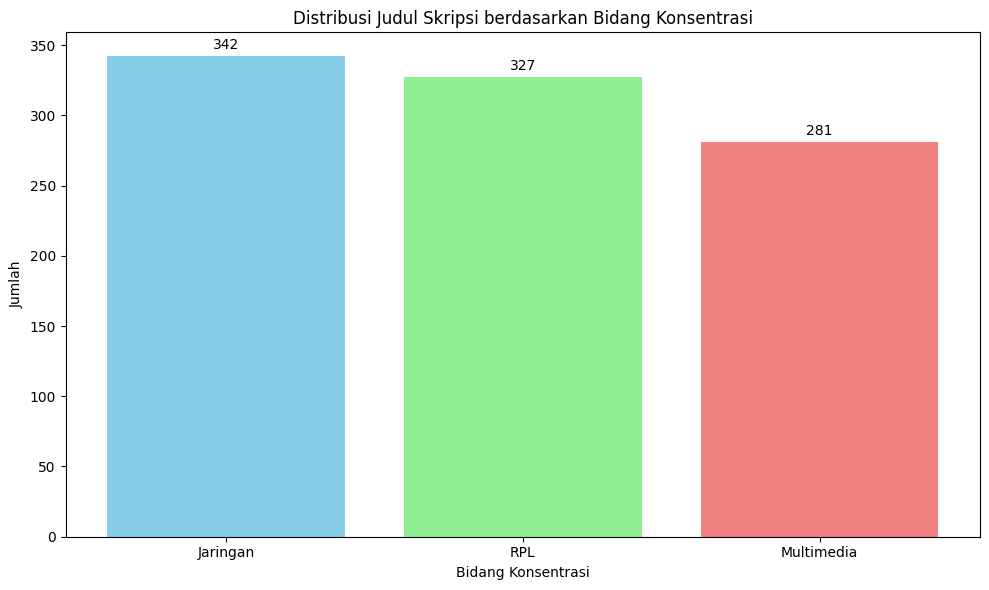


Statistik Jumlah Kata Berdasarkan Bidang Konsentrasi:
                 mean  median  min  max
label                                  
Jaringan    15.172515    16.0    3   26
Multimedia  13.971530    14.0    6   23
RPL         13.431193    14.0    5   22


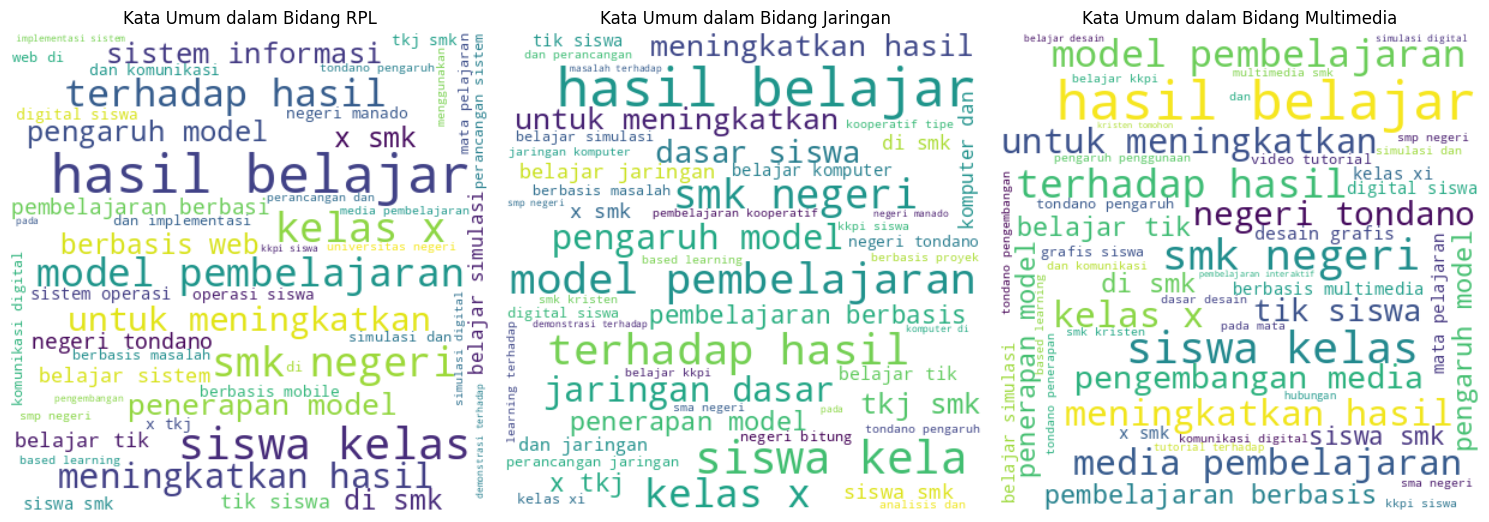

In [ ]:
print("\nMelakukan pelabelan otomatis berdasarkan bidang konsentrasi...")
# Fungsi pelabelan otomatis sederhana berdasarkan kata kunci
def assign_label(title):
    title_lower = str(title).lower()

    # Kata kunci untuk RPL
    rpl_keywords = ['sistem', 'aplikasi', 'web', 'android', 'software', 'perangkat lunak',
                   'database', 'basis data', 'framework', 'e-commerce', 'situs web',
                   'website', 'mobile', 'pemrograman', 'program', 'coding', 'informasi']

    # Kata kunci untuk Jaringan
    network_keywords = ['jaringan', 'network', 'wifi', 'lan', 'wan', 'server', 'router',
                       'protocol', 'protokol', 'tcp/ip', 'keamanan jaringan', 'security',
                       'komputer', 'bandwidth', 'monitoring', 'firewall', 'topologi']

    # Kata kunci untuk Multimedia
    multimedia_keywords = ['multimedia', 'game', 'permainan', 'animasi', 'grafis', 'visual',
                          'audio', 'video', 'interaktif', 'augmented reality', 'virtual reality',
                          'desain', 'gambar', 'media', 'edukasi', '3d', 'user interface']

    # Hitung kemunculan kata kunci
    rpl_count = sum(1 for keyword in rpl_keywords if keyword in title_lower)
    network_count = sum(1 for keyword in network_keywords if keyword in title_lower)
    multimedia_count = sum(1 for keyword in multimedia_keywords if keyword in title_lower)

    # Tentukan label berdasarkan kemunculan kata kunci terbanyak
    counts = {'RPL': rpl_count, 'Jaringan': network_count, 'Multimedia': multimedia_count}
    max_category = max(counts, key=counts.get)

    # Jika tidak ada kata kunci yang cocok, pilih secara acak
    if counts[max_category] == 0:
        return random.choice(['RPL', 'Jaringan', 'Multimedia'])

    return max_category

# Terapkan fungsi pelabelan
df['label'] = df['judul_clean'].apply(assign_label)

# Tampilkan distribusi label
label_counts = df['label'].value_counts()
print("\nDistribusi Bidang Konsentrasi:")
for label, count in label_counts.items():
    print(f"{label}: {count} ({count/len(df)*100:.2f}%)")

# Visualisasi distribusi label
plt.figure(figsize=(10, 6))
bars = plt.bar(label_counts.index, label_counts.values, color=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Distribusi Judul Skripsi berdasarkan Bidang Konsentrasi')
plt.xlabel('Bidang Konsentrasi')
plt.ylabel('Jumlah')

# Tambahkan nilai di atas bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5, str(height), ha='center')

plt.savefig('output/distribusi_label.png')
plt.tight_layout()
plt.show()

# Statistik jumlah kata berdasarkan kategori
word_counts_by_category = df.groupby('label')['word_count'].agg(['mean', 'median', 'min', 'max'])
print("\nStatistik Jumlah Kata Berdasarkan Bidang Konsentrasi:")
print(word_counts_by_category)

# Visualisasi kata-kata umum untuk setiap kategori
plt.figure(figsize=(15, 10))
categories = ['RPL', 'Jaringan', 'Multimedia']
for i, category in enumerate(categories):
    category_texts = ' '.join(df[df['label'] == category]['judul_clean'])

    plt.subplot(1, 3, i+1)
    wordcloud = WordCloud(width=400, height=400, background_color='white',
                          max_words=50, contour_width=3).generate(category_texts)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Kata Umum dalam Bidang {category}')
    plt.axis('off')

plt.savefig('output/wordcloud_by_category.png')
plt.tight_layout()
plt.show()

# **5. Ekstraksi Fitur Semantic Berbasis IndoBERT**

In [ ]:
print("\n=== EKSTRAKSI FITUR SEMANTIC BERBASIS INDOBERT ===")
print("Mengekstrak representasi semantik menggunakan IndoBERT...")

# Load IndoBERT
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model = AutoModel.from_pretrained("indobenchmark/indobert-base-p1")

# Fungsi untuk mendapatkan embedding BERT
def get_bert_embedding(text, tokenizer, model):
    # Preprocessing teks
    text = preprocess_text(text)

    # Tokenisasi
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)

    # Forward pass, get hidden states
    with torch.no_grad():
        outputs = model(**inputs)

    # Extract [CLS] embedding (sentence representation)
    sentence_embedding = outputs.last_hidden_state[:, 0, :].numpy().squeeze()
    return sentence_embedding

# Ekstrak embedding untuk semua judul
embeddings = []
for idx, text in enumerate(df['judul_clean']):
    if idx % 50 == 0:
        print(f"Mengekstrak embedding untuk judul ke-{idx}...")
    embedding = get_bert_embedding(text, tokenizer, model)
    embeddings.append(embedding)

# Konversi ke numpy array
embeddings_array = np.array(embeddings)
print(f"Dimensi representasi semantik: {embeddings_array.shape}")

# Simpan embeddings
np.save('models/indobert_embeddings.npy', embeddings_array)
print("Representasi semantik berhasil disimpan")


=== EKSTRAKSI FITUR SEMANTIC BERBASIS INDOBERT ===
Mengekstrak representasi semantik menggunakan IndoBERT...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Mengekstrak embedding untuk judul ke-0...


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Mengekstrak embedding untuk judul ke-50...
Mengekstrak embedding untuk judul ke-100...
Mengekstrak embedding untuk judul ke-150...
Mengekstrak embedding untuk judul ke-200...
Mengekstrak embedding untuk judul ke-250...
Mengekstrak embedding untuk judul ke-300...
Mengekstrak embedding untuk judul ke-350...
Mengekstrak embedding untuk judul ke-400...
Mengekstrak embedding untuk judul ke-450...
Mengekstrak embedding untuk judul ke-500...
Mengekstrak embedding untuk judul ke-550...
Mengekstrak embedding untuk judul ke-600...
Mengekstrak embedding untuk judul ke-650...
Mengekstrak embedding untuk judul ke-700...
Mengekstrak embedding untuk judul ke-750...
Mengekstrak embedding untuk judul ke-800...
Mengekstrak embedding untuk judul ke-850...
Mengekstrak embedding untuk judul ke-900...
Dimensi representasi semantik: (950, 768)
Representasi semantik berhasil disimpan


# **6. Analisis Semantic Similarity**


=== ANALISIS SEMANTIC SIMILARITY ===


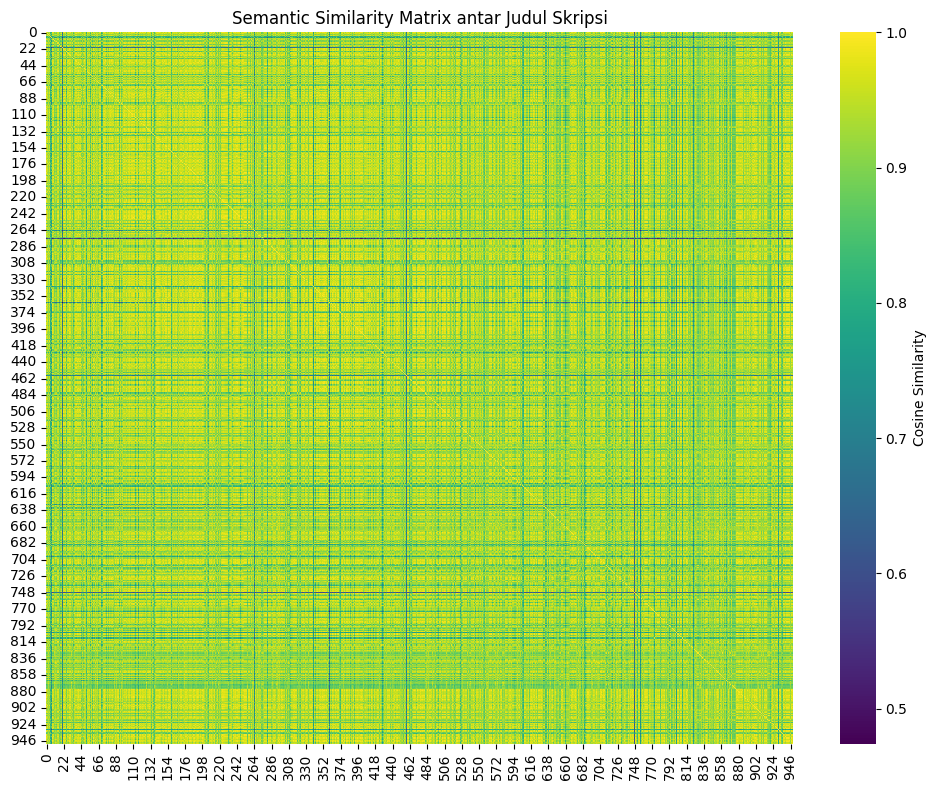


Rata-rata Semantic Similarity dalam Bidang Konsentrasi yang Sama:
RPL: 0.9178
Jaringan: 0.9341
Multimedia: 0.9182


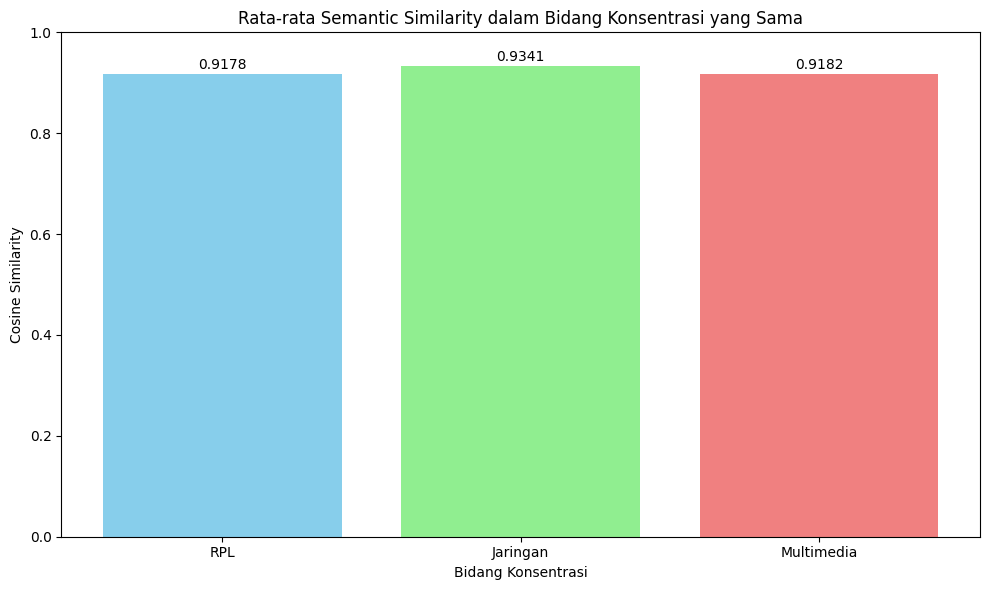

In [ ]:
print("\n=== ANALISIS SEMANTIC SIMILARITY ===")

# Hitung similarity matrix menggunakan cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(embeddings_array)

# Visualisasi similarity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, cmap='viridis', cbar_kws={'label': 'Cosine Similarity'})
plt.title('Semantic Similarity Matrix antar Judul Skripsi')
plt.savefig('output/similarity_matrix.png')
plt.tight_layout()
plt.show()

# Rata-rata similarity dalam kelas yang sama
intra_class_similarity = {}
for category in categories:
    indices = df[df['label'] == category].index.tolist()
    if len(indices) > 1:  # Perlu minimal 2 sampel untuk menghitung similarity
        class_sim = similarity_matrix[np.ix_(indices, indices)]
        # Ambil similarity antar dokumen, bukan dengan diri sendiri
        class_sim = class_sim[~np.eye(class_sim.shape[0], dtype=bool)].mean()
        intra_class_similarity[category] = class_sim

print("\nRata-rata Semantic Similarity dalam Bidang Konsentrasi yang Sama:")
for category, sim in intra_class_similarity.items():
    print(f"{category}: {sim:.4f}")

# Visualisasi rata-rata intra-class similarity
plt.figure(figsize=(10, 6))
bars = plt.bar(intra_class_similarity.keys(), intra_class_similarity.values(),
               color=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Rata-rata Semantic Similarity dalam Bidang Konsentrasi yang Sama')
plt.xlabel('Bidang Konsentrasi')
plt.ylabel('Cosine Similarity')

# Tambahkan nilai di atas bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.4f}', ha='center')

plt.ylim(0, 1)
plt.savefig('output/intra_class_similarity.png')
plt.tight_layout()
plt.show()

# **7. Visualisasi Dengan t-SNE dan PCA**


Menganalisis persebaran data dengan t-SNE...


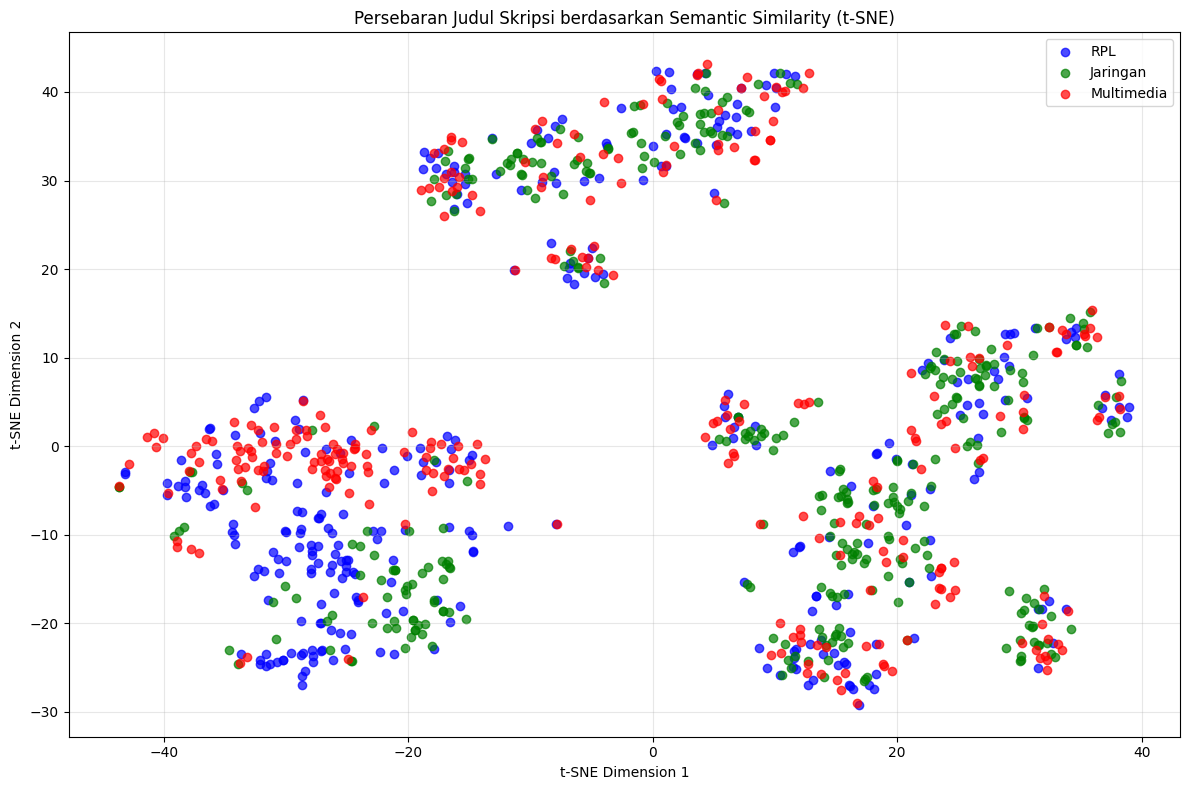


Melakukan reduksi dimensi dengan PCA untuk visualisasi...
Variance explained by PCA: 0.4573


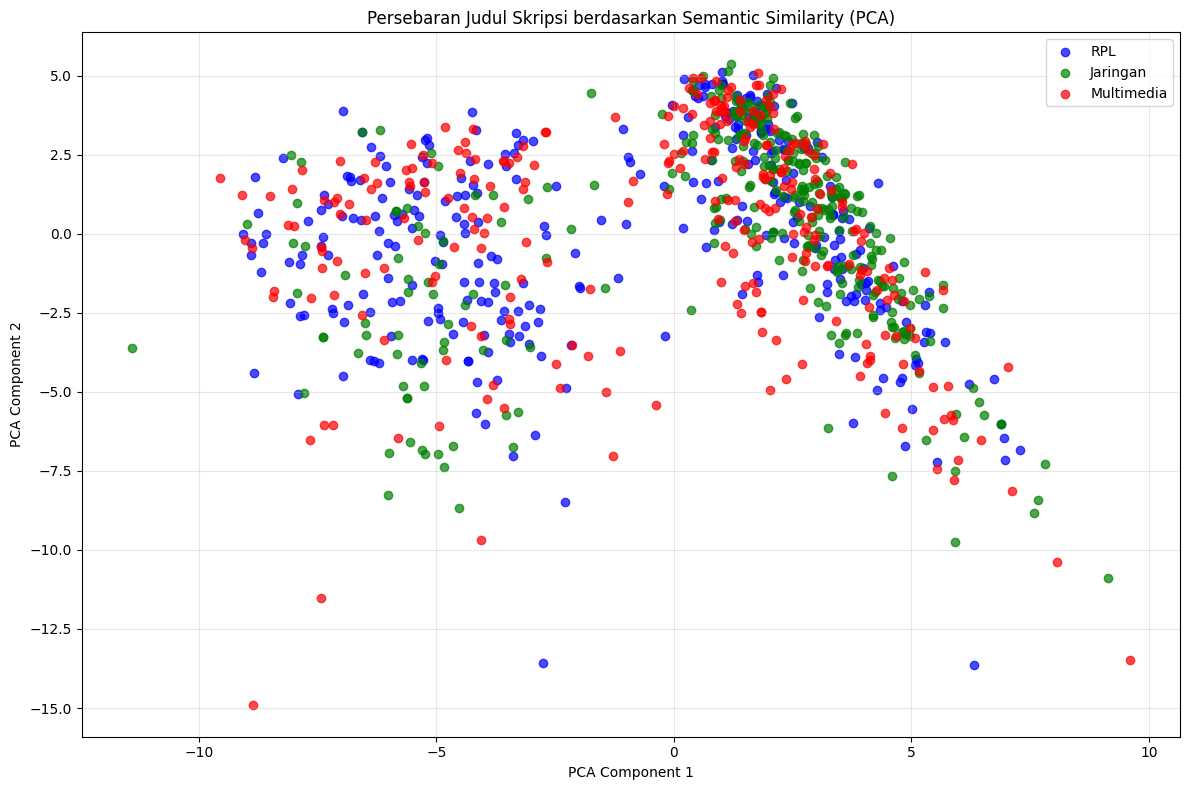

In [ ]:
# Visualisasi persebaran data dengan t-SNE berdasarkan semantic similarity
print("\nMenganalisis persebaran data dengan t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(df) - 1))
tsne_result = tsne.fit_transform(embeddings_array)

plt.figure(figsize=(12, 8))
colors = {'RPL': 'blue', 'Jaringan': 'green', 'Multimedia': 'red'}
for category in categories:
    indices = df[df['label'] == category].index.tolist()
    plt.scatter(tsne_result[indices, 0], tsne_result[indices, 1],
                c=colors[category], label=category, alpha=0.7)

plt.title('Persebaran Judul Skripsi berdasarkan Semantic Similarity (t-SNE)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('output/tsne_visualization.png')
plt.tight_layout()
plt.show()

# Reduksi dimensi dengan PCA
print("\nMelakukan reduksi dimensi dengan PCA untuk visualisasi...")
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings_array)
print(f"Variance explained by PCA: {pca.explained_variance_ratio_.sum():.4f}")

plt.figure(figsize=(12, 8))
for category in categories:
    indices = df[df['label'] == category].index.tolist()
    plt.scatter(pca_result[indices, 0], pca_result[indices, 1],
                c=colors[category], label=category, alpha=0.7)

plt.title('Persebaran Judul Skripsi berdasarkan Semantic Similarity (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('output/pca_visualization.png')
plt.tight_layout()
plt.show()

# **8. Persiapan Data Training dan Testing**

In [ ]:
# Split data untuk training dan testing
print("\nMembagi data untuk training dan testing...")
X_train, X_test, y_train, y_test = train_test_split(
    embeddings_array, df['label'], test_size=0.2, random_state=42, stratify=df['label']
)
print(f"Jumlah data training: {len(X_train)}, Jumlah data testing: {len(X_test)}")


Membagi data untuk training dan testing...
Jumlah data training: 760, Jumlah data testing: 190


# **9. Hyperparameter Tuning untuk KNN**

In [ ]:
print("\n=== HYPERPARAMETER TUNING UNTUK KNN ===")
# Parameter grid untuk KNN
knn_param_grid = {
   'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
   'weights': ['uniform', 'distance'],
   'metric': ['euclidean', 'manhattan', 'cosine', 'minkowski'],
   'p': [1, 2]  # Relevant for minkowski
}

# GridSearchCV untuk KNN dengan pesan peringatan dimatikan
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# GridSearchCV untuk KNN
knn_grid = GridSearchCV(
   KNeighborsClassifier(),
   param_grid=knn_param_grid,
   cv=5,
   scoring='accuracy',
   n_jobs=-1,
   verbose=1
)

knn_grid.fit(X_train, y_train)
best_knn = knn_grid.best_estimator_

print(f"\nParameter KNN terbaik:")
for param, value in knn_grid.best_params_.items():
   print(f"  {param}: {value}")
print(f"Akurasi KNN terbaik pada validasi: {knn_grid.best_score_:.4f}")


=== HYPERPARAMETER TUNING UNTUK KNN ===
Fitting 5 folds for each of 112 candidates, totalling 560 fits

Parameter KNN terbaik:
  metric: manhattan
  n_neighbors: 3
  p: 1
  weights: distance
Akurasi KNN terbaik pada validasi: 0.5816


# **10. Hyperparameter Tuning untuk Decision Tree**

In [ ]:
print("\n=== HYPERPARAMETER TUNING UNTUK DECISION TREE ===")
# Parameter grid untuk Decision Tree
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8]
}

# GridSearchCV untuk Decision Tree
dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=dt_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

dt_grid.fit(X_train, y_train)
best_dt = dt_grid.best_estimator_

print(f"\nParameter Decision Tree terbaik:")
for param, value in dt_grid.best_params_.items():
    print(f"  {param}: {value}")
print(f"Akurasi Decision Tree terbaik pada validasi: {dt_grid.best_score_:.4f}")


=== HYPERPARAMETER TUNING UNTUK DECISION TREE ===
Fitting 5 folds for each of 120 candidates, totalling 600 fits

Parameter Decision Tree terbaik:
  criterion: gini
  max_depth: 10
  min_samples_leaf: 1
  min_samples_split: 10
Akurasi Decision Tree terbaik pada validasi: 0.4961


# **11. Evaluasi Model KNN**


=== EVALUASI MODEL KNN ===
Akurasi KNN: 0.5263
Precision KNN: 0.5225
Recall KNN: 0.5263
F1-score KNN: 0.5175


<Figure size 800x600 with 0 Axes>

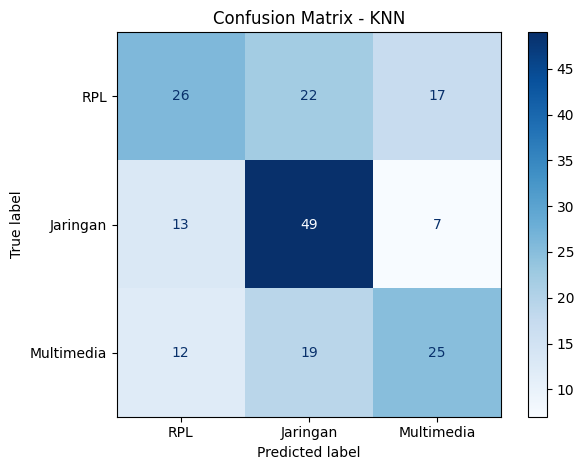


Classification Report untuk KNN:
              precision    recall  f1-score   support

         RPL       0.54      0.71      0.62        69
    Jaringan       0.51      0.45      0.48        56
  Multimedia       0.51      0.40      0.45        65

    accuracy                           0.53       190
   macro avg       0.52      0.52      0.51       190
weighted avg       0.52      0.53      0.52       190



In [ ]:
print("\n=== EVALUASI MODEL KNN ===")
# Prediksi pada data testing
knn_y_pred = best_knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_y_pred)
knn_precision = precision_score(y_test, knn_y_pred, average='weighted')
knn_recall = recall_score(y_test, knn_y_pred, average='weighted')
knn_f1 = f1_score(y_test, knn_y_pred, average='weighted')

print(f"Akurasi KNN: {knn_accuracy:.4f}")
print(f"Precision KNN: {knn_precision:.4f}")
print(f"Recall KNN: {knn_recall:.4f}")
print(f"F1-score KNN: {knn_f1:.4f}")

# Confusion Matrix untuk KNN
knn_cm = confusion_matrix(y_test, knn_y_pred, labels=categories)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=knn_cm, display_labels=categories)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - KNN')
plt.savefig('output/knn_confusion_matrix.png')
plt.tight_layout()
plt.show()

print("\nClassification Report untuk KNN:")
print(classification_report(y_test, knn_y_pred, target_names=categories))

# **12. Evaluasi Model Decision Tree**


=== EVALUASI MODEL DECISION TREE ===
Akurasi Decision Tree: 0.5263
Precision Decision Tree: 0.5250
Recall Decision Tree: 0.5263
F1-score Decision Tree: 0.5226


<Figure size 800x600 with 0 Axes>

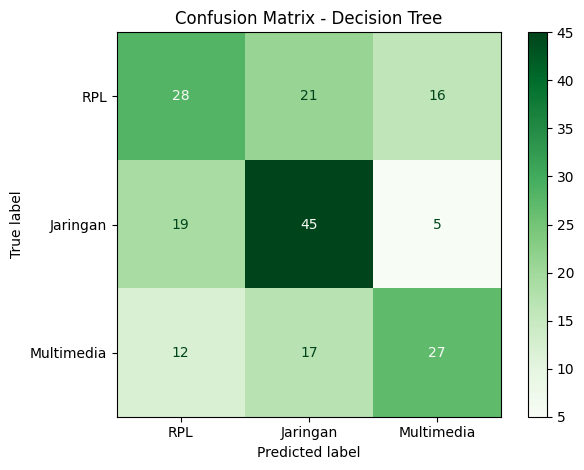


Classification Report untuk Decision Tree:
              precision    recall  f1-score   support

         RPL       0.54      0.65      0.59        69
    Jaringan       0.56      0.48      0.52        56
  Multimedia       0.47      0.43      0.45        65

    accuracy                           0.53       190
   macro avg       0.53      0.52      0.52       190
weighted avg       0.53      0.53      0.52       190

Decision tree terlalu besar untuk divisualisasikan.


In [ ]:
print("\n=== EVALUASI MODEL DECISION TREE ===")
# Prediksi pada data testing
dt_y_pred = best_dt.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_y_pred)
dt_precision = precision_score(y_test, dt_y_pred, average='weighted')
dt_recall = recall_score(y_test, dt_y_pred, average='weighted')
dt_f1 = f1_score(y_test, dt_y_pred, average='weighted')

print(f"Akurasi Decision Tree: {dt_accuracy:.4f}")
print(f"Precision Decision Tree: {dt_precision:.4f}")
print(f"Recall Decision Tree: {dt_recall:.4f}")
print(f"F1-score Decision Tree: {dt_f1:.4f}")

# Confusion Matrix untuk Decision Tree
dt_cm = confusion_matrix(y_test, dt_y_pred, labels=categories)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=dt_cm, display_labels=categories)
disp.plot(cmap='Greens')
plt.title('Confusion Matrix - Decision Tree')
plt.savefig('output/dt_confusion_matrix.png')
plt.tight_layout()
plt.show()

print("\nClassification Report untuk Decision Tree:")
print(classification_report(y_test, dt_y_pred, target_names=categories))

# Visualisasi Decision Tree (jika tidak terlalu besar)
if best_dt.tree_.node_count < 50:
    plt.figure(figsize=(20, 15))
    plot_tree(best_dt, filled=True, feature_names=np.arange(embeddings_array.shape[1]),
              class_names=categories, rounded=True)
    plt.title("Visualisasi Decision Tree")
    plt.savefig('output/decision_tree_visualization.png')
    plt.tight_layout()
    plt.show()
else:
    print("Decision tree terlalu besar untuk divisualisasikan.")

# **13. Analisis Perbandingan Kinerja**


=== ANALISIS PERBANDINGAN KINERJA ===
Melakukan cross-validation...
Cross-validation KNN: 0.5537 (std: 0.0505)
Cross-validation Decision Tree: 0.5021 (std: 0.0288)


<Figure size 1000x600 with 0 Axes>

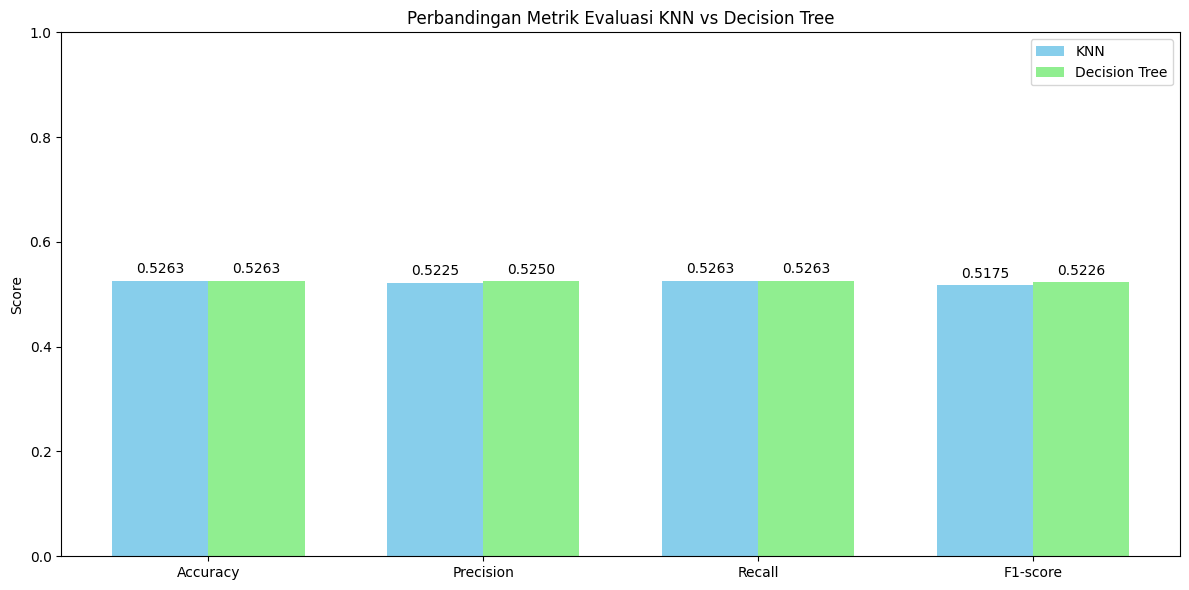

<ipython-input-13-aa9c8c9fd50d>:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([knn_cv_scores, dt_cv_scores], labels=['KNN', 'Decision Tree'])


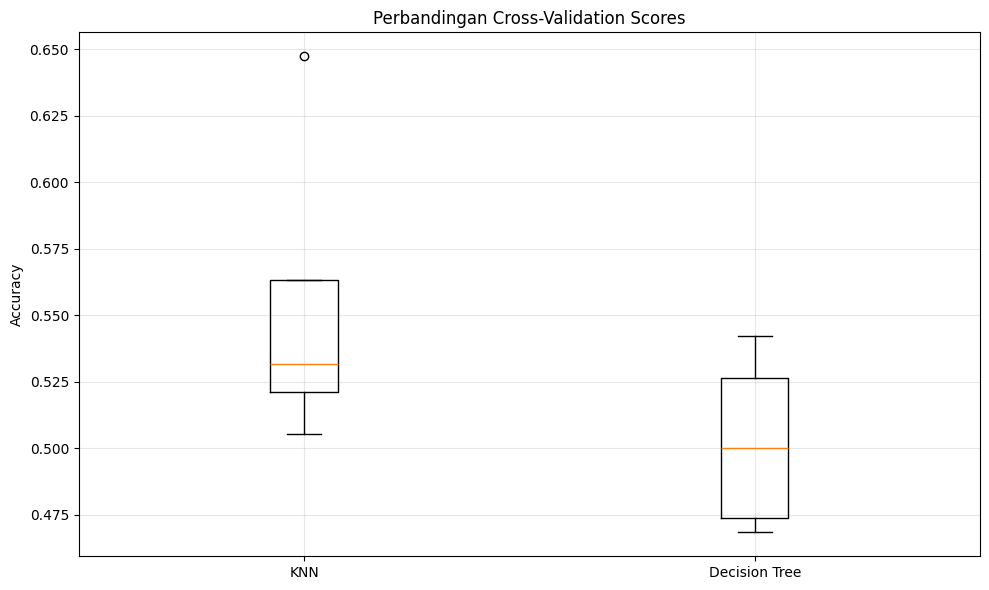

In [ ]:
print("\n=== ANALISIS PERBANDINGAN KINERJA ===")
# Cross-validation untuk evaluasi yang lebih robust
print("Melakukan cross-validation...")
knn_cv_scores = cross_val_score(best_knn, embeddings_array, df['label'], cv=5, scoring='accuracy')
dt_cv_scores = cross_val_score(best_dt, embeddings_array, df['label'], cv=5, scoring='accuracy')

print(f"Cross-validation KNN: {knn_cv_scores.mean():.4f} (std: {knn_cv_scores.std():.4f})")
print(f"Cross-validation Decision Tree: {dt_cv_scores.mean():.4f} (std: {dt_cv_scores.std():.4f})")

# Visualisasi perbandingan akurasi
plt.figure(figsize=(10, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
knn_scores = [knn_accuracy, knn_precision, knn_recall, knn_f1]
dt_scores = [dt_accuracy, dt_precision, dt_recall, dt_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, knn_scores, width, label='KNN', color='skyblue')
rects2 = ax.bar(x + width/2, dt_scores, width, label='Decision Tree', color='lightgreen')

ax.set_title('Perbandingan Metrik Evaluasi KNN vs Decision Tree')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1)
ax.set_ylabel('Score')
ax.legend()

# Tambahkan nilai di atas bar
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)

plt.savefig('output/performance_comparison.png')
plt.tight_layout()
plt.show()

# Visualisasi perbandingan cross-validation
plt.figure(figsize=(10, 6))
plt.boxplot([knn_cv_scores, dt_cv_scores], labels=['KNN', 'Decision Tree'])
plt.title('Perbandingan Cross-Validation Scores')
plt.ylabel('Accuracy')
plt.grid(alpha=0.3)
plt.savefig('output/cv_comparison.png')
plt.tight_layout()
plt.show()

# **14. Analisis Sensitivitas KNN Terhadap Jumlah Neighbors**


=== ANALISIS SENSITIVITAS KNN TERHADAP JUMLAH NEIGHBORS ===
k=1: 0.5495
k=3: 0.5547
k=5: 0.5505
k=7: 0.5537
k=9: 0.5537
k=11: 0.5516
k=13: 0.5474
k=15: 0.5537
k=17: 0.5547
k=19: 0.5579


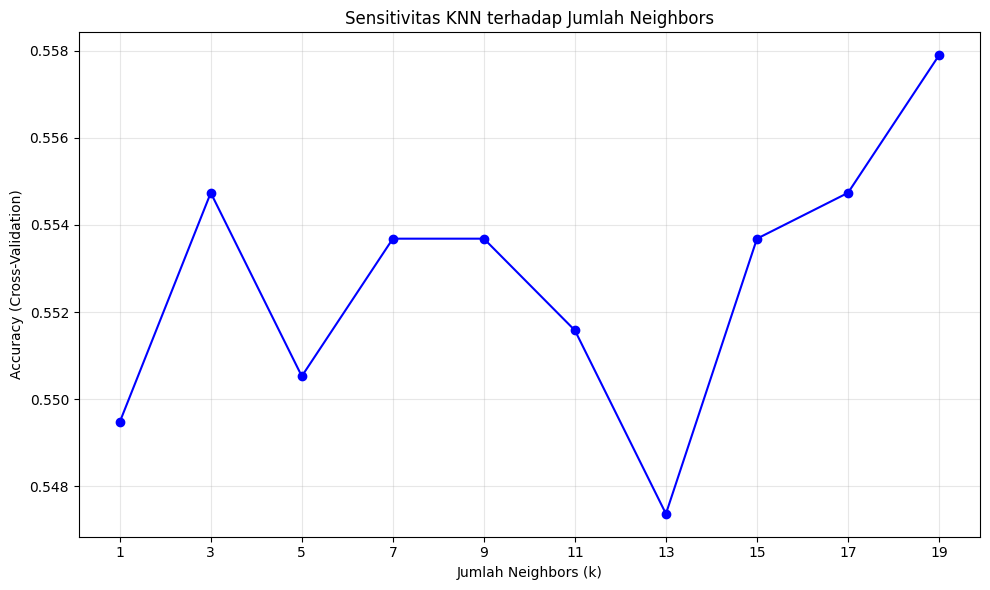

In [ ]:
print("\n=== ANALISIS SENSITIVITAS KNN TERHADAP JUMLAH NEIGHBORS ===")
k_values = list(range(1, 21, 2))  # k = 1, 3, 5, ..., 19
k_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', metric='cosine')
    scores = cross_val_score(knn, embeddings_array, df['label'], cv=5, scoring='accuracy')
    k_scores.append(scores.mean())
    print(f"k={k}: {scores.mean():.4f}")

# Visualisasi sensitivitas KNN terhadap jumlah neighbors
plt.figure(figsize=(10, 6))
plt.plot(k_values, k_scores, 'o-', color='blue')
plt.title('Sensitivitas KNN terhadap Jumlah Neighbors')
plt.xlabel('Jumlah Neighbors (k)')
plt.ylabel('Accuracy (Cross-Validation)')
plt.xticks(k_values)
plt.grid(alpha=0.3)
plt.savefig('output/knn_sensitivity.png')
plt.tight_layout()
plt.show()

# **15. Analisis Sensitivitas Decision Tree Terhadap Max Depth**


=== ANALISIS SENSITIVITAS DECISION TREE TERHADAP MAX DEPTH ===
max_depth=1: Train=0.4579, Test=0.4368
max_depth=2: Train=0.5408, Test=0.5105
max_depth=3: Train=0.5921, Test=0.4947
max_depth=5: Train=0.7289, Test=0.4895
max_depth=7: Train=0.8289, Test=0.4895
max_depth=10: Train=0.9526, Test=0.5000
max_depth=15: Train=0.9974, Test=0.4947
max_depth=20: Train=1.0000, Test=0.5211
max_depth=25: Train=1.0000, Test=0.5211
max_depth=30: Train=1.0000, Test=0.5211
max_depth=None: Train=1.0000, Test=0.5211


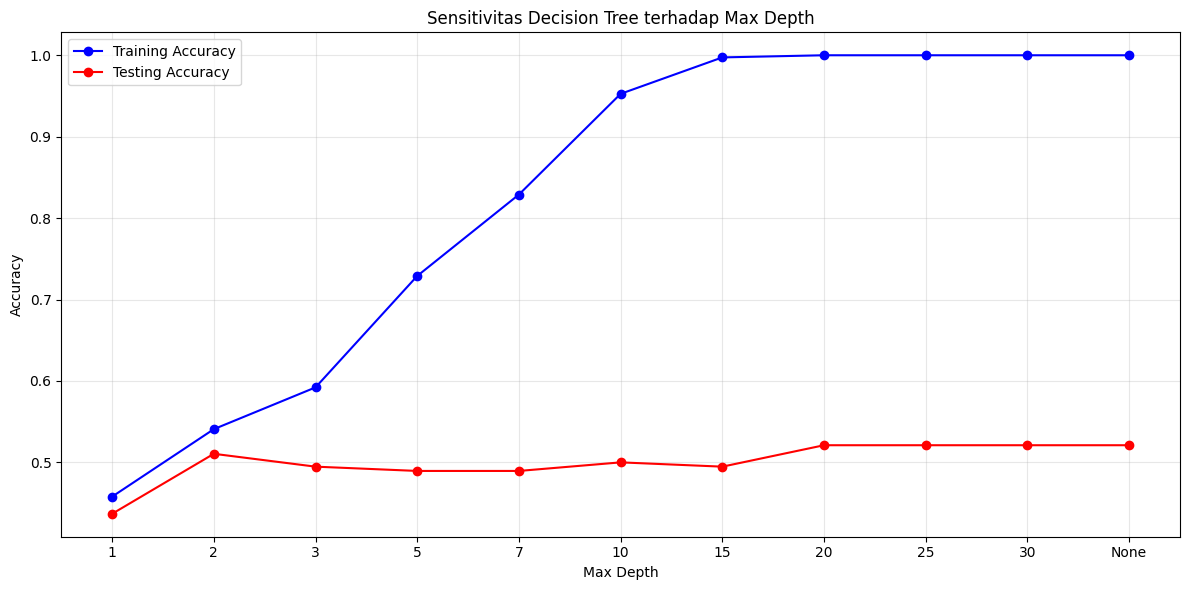

In [ ]:
print("\n=== ANALISIS SENSITIVITAS DECISION TREE TERHADAP MAX DEPTH ===")
depth_values = [1, 2, 3, 5, 7, 10, 15, 20, 25, 30, None]  # None berarti tidak dibatasi
depth_train_scores = []
depth_test_scores = []

for depth in depth_values:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)
    train_score = accuracy_score(y_train, dt.predict(X_train))
    test_score = accuracy_score(y_test, dt.predict(X_test))
    depth_train_scores.append(train_score)
    depth_test_scores.append(test_score)
    print(f"max_depth={depth}: Train={train_score:.4f}, Test={test_score:.4f}")

# Visualisasi sensitivitas Decision Tree terhadap max_depth
plt.figure(figsize=(12, 6))
plt.plot(range(len(depth_values)), depth_train_scores, 'o-', color='blue', label='Training Accuracy')
plt.plot(range(len(depth_values)), depth_test_scores, 'o-', color='red', label='Testing Accuracy')
plt.title('Sensitivitas Decision Tree terhadap Max Depth')
plt.xlabel('Max Depth')
plt.xticks(range(len(depth_values)), [str(d) for d in depth_values])
plt.ylabel('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('output/dt_sensitivity.png')
plt.tight_layout()
plt.show()

# **16. Sistem Prediksi Bidang Konsentrasi untuk Judul Baru**

In [ ]:
print("\n=== SISTEM PREDIKSI BIDANG KONSENTRASI UNTUK JUDUL BARU ===")

def predict_concentration(title, knn_model, dt_model, tokenizer, bert_model):
    """
    Memprediksi bidang konsentrasi untuk judul skripsi baru

    Parameters:
        title (str): Judul skripsi
        knn_model: Model KNN terlatih
        dt_model: Model Decision Tree terlatih
        tokenizer: Tokenizer IndoBERT
        bert_model: Model IndoBERT

    Returns:
        dict: Hasil prediksi dan confidence
    """
    # Preprocessing
    clean_title = preprocess_text(title)

    # Ekstrak embedding
    embedding = get_bert_embedding(clean_title, tokenizer, bert_model)
    embedding = embedding.reshape(1, -1)  # Reshape untuk input model

    # Prediksi KNN
    knn_prediction = knn_model.predict(embedding)[0]
    knn_proba = knn_model.predict_proba(embedding)[0]
    knn_confidence = knn_proba.max()

    # Prediksi Decision Tree
    dt_prediction = dt_model.predict(embedding)[0]
    dt_proba = dt_model.predict_proba(embedding)[0]
    dt_confidence = dt_proba.max()

    # Similaritas dengan representasi rata-rata per kategori
    category_similarities = {}
    category_centroids = {}

    for category in categories:
        indices = df[df['label'] == category].index.tolist()
        category_embeddings = embeddings_array[indices]
        centroid = category_embeddings.mean(axis=0)
        category_centroids[category] = centroid
        similarity = cosine_similarity(embedding, centroid.reshape(1, -1))[0][0]
        category_similarities[category] = similarity

    most_similar_category = max(category_similarities, key=category_similarities.get)

    return {
        'KNN': {'prediction': knn_prediction, 'confidence': knn_confidence},
        'Decision Tree': {'prediction': dt_prediction, 'confidence': dt_confidence},
        'Similarity': {'prediction': most_similar_category,
                       'confidence': category_similarities[most_similar_category]},
        'All Similarities': category_similarities
    }

# Judul skripsi baru untuk prediksi
new_titles = [
    "Rancang Bangun Sistem Informasi Akademik Berbasis Web",
    "Implementasi Jaringan Komputer pada Laboratorium Sekolah",
    "Pengembangan Game Edukasi untuk Pembelajaran Matematika",
    "Analisis Performa Jaringan 5G pada Infrastruktur Kampus",
    "Pengembangan Aplikasi Android untuk Manajemen Inventaris"
]

# Prediksi untuk judul baru
print("\nPrediksi bidang konsentrasi untuk judul baru:")
for title in new_titles:
    print(f"\nJudul: {title}")
    results = predict_concentration(title, best_knn, best_dt, tokenizer, model)

    for model_name, result in results.items():
        if model_name != 'All Similarities':
            print(f"  {model_name}: {result['prediction']} (confidence: {result['confidence']:.4f})")

    print("  Similarity dengan setiap bidang konsentrasi:")
    for category, similarity in results['All Similarities'].items():
        print(f"    {category}: {similarity:.4f}")


=== SISTEM PREDIKSI BIDANG KONSENTRASI UNTUK JUDUL BARU ===

Prediksi bidang konsentrasi untuk judul baru:

Judul: Rancang Bangun Sistem Informasi Akademik Berbasis Web
  KNN: RPL (confidence: 1.0000)
  Decision Tree: RPL (confidence: 1.0000)
  Similarity: RPL (confidence: 0.9419)
  Similarity dengan setiap bidang konsentrasi:
    RPL: 0.9419
    Jaringan: 0.9152
    Multimedia: 0.9303

Judul: Implementasi Jaringan Komputer pada Laboratorium Sekolah
  KNN: Jaringan (confidence: 1.0000)
  Decision Tree: Jaringan (confidence: 0.9187)
  Similarity: RPL (confidence: 0.9535)
  Similarity dengan setiap bidang konsentrasi:
    RPL: 0.9535
    Jaringan: 0.9358
    Multimedia: 0.9449

Judul: Pengembangan Game Edukasi untuk Pembelajaran Matematika
  KNN: Multimedia (confidence: 0.6897)
  Decision Tree: Multimedia (confidence: 0.5000)
  Similarity: Multimedia (confidence: 0.9259)
  Similarity dengan setiap bidang konsentrasi:
    RPL: 0.9255
    Jaringan: 0.9022
    Multimedia: 0.9259

Judul: An

# **17. Menyimpan Model dan Hasil**

In [ ]:
# Simpan model terbaik
joblib.dump(best_knn, 'models/best_knn_model.pkl')
joblib.dump(best_dt, 'models/best_decision_tree_model.pkl')
print("\nModel-model terbaik berhasil disimpan")

# Simpan centroid per kategori untuk referensi future predictions
category_centroids = {}
for category in categories:
    indices = df[df['label'] == category].index.tolist()
    category_embeddings = embeddings_array[indices]
    centroid = category_embeddings.mean(axis=0)
    category_centroids[category] = centroid

joblib.dump(category_centroids, 'models/category_centroids.pkl')
print("Centroid per kategori berhasil disimpan")

# Waktu eksekusi
total_time = time.time() - start_time
print(f"\nTotal waktu eksekusi: {total_time:.2f} detik ({total_time/60:.2f} menit)")

print("\n=== PROSES ANALISIS SELESAI ===")
print("Hasil analisis dan model tersimpan di folder 'output' dan 'models'")


Model-model terbaik berhasil disimpan
Centroid per kategori berhasil disimpan

Total waktu eksekusi: 652.29 detik (10.87 menit)

=== PROSES ANALISIS SELESAI ===
Hasil analisis dan model tersimpan di folder 'output' dan 'models'
